In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
font = {'size'   : 22}
rc('font', **font)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
rc('text', usetex=True)
plt.rcParams['font.family']='Computer Modern'
import scipy.stats as st
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statistics
import os
import pandas as pd
from functions import *

/Users/manuelszewc/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In this Notebook we take the learned output values to compute the Mutual Information and its associated p-value

# Dir definition

In [2]:
WPs_dir='training/'

In [3]:
results_dir='plots/'

In [4]:
y_together = np.load('y_RandD.npy')
labels_together = np.load('labels_RandD.npy')
x_together = np.load('x_RandD.npy')
x_together[:,0]=x_together[:,0]#-x_together[:,1]
nB = np.sum(labels_together==0.0)
print(nB)
x_sim = np.load('x_BB1.npy')
x_sim[:,0]=x_sim[:,0]#-x_sim[:,1]
y_sim = np.load('y_BB1.npy')
labels_sim = np.load('labels_BB1.npy')
x_sim=x_sim[labels_sim==0.0]
y_sim=y_sim[labels_sim==0.0]

999899


# WP choice

We decide which $S/B$ we want to consider and which $\lambda$s we want to compare.

In [5]:
lambdas_values = np.load(WPs_dir+'lambda_values.npy')
print(lambdas_values)
soverbs_vals = np.load(WPs_dir+'soverbs.npy')
print(soverbs_vals)
soverbs_labels = np.load(WPs_dir+'soverbs_labels.npy')
print(soverbs_labels)

[0. 1.]
[0.     0.0007 0.0014 0.0035]
['0.0' '0.0025' '0.005' '0.01']


In [6]:
nSoverB = 1
SoverB = soverbs_vals[nSoverB]
SoverB_label = soverbs_labels[nSoverB]

nlambda_val_old = 0#np.argmin(Imeasured[nSoverB])
lambda_val_old = lambdas_values[nlambda_val_old]

nlambda_val = 1#np.argmin(Imeasured[nSoverB])
lambda_val = lambdas_values[nlambda_val]


In [7]:
s_values_full = np.load(WPs_dir+'s_values_'+str(nSoverB)+'.npy')
s_values_old=s_values_full[nlambda_val_old]
s_values=s_values_full[nlambda_val]

s_values_sim_full = np.load(WPs_dir+'s_values_sim_'+str(nSoverB)+'.npy')
s_values_sim=s_values_sim_full[nlambda_val]

In [8]:
nS = int(SoverB*nB)#np.sum(labels_together==1.0)#
print(nB,nS)
y_together_bis=y_together[:nB+nS]
labels_together_bis=labels_together[:nB+nS]
x_together_bis=x_together[:nB+nS]    
scaler = StandardScaler()
x_together_bis = scaler.fit_transform(x_together_bis)#labels_together.reshape(-1,1)
x_sim_bis = scaler.transform(x_sim)
minmax = MinMaxScaler()
y_together_bis = y_together_bis#minmax.fit_transform(y_together.reshape(-1,1))[:,0]
y_sim_bis = y_sim

# same as 2009.02205
y_low = 3100.0
y_high = 3900.0

x_together_bis=x_together_bis[y_together_bis>=y_low]
labels_together_bis=labels_together_bis[y_together_bis>=y_low]
y_together_bis=y_together_bis[y_together_bis>=y_low]

x_sim_bis = x_sim_bis[y_sim_bis>=y_low]
y_sim_bis = y_sim_bis[y_sim_bis>=y_low]

x_together_bis=x_together_bis[y_together_bis<=y_high]
labels_together_bis=labels_together_bis[y_together_bis<=y_high]
y_together_bis=y_together_bis[y_together_bis<=y_high]

x_sim_bis = x_sim_bis[y_sim_bis<=y_high]
y_sim_bis = y_sim_bis[y_sim_bis<=y_high]
    
y_nbins=25
y_bins = np.array([np.quantile(y_together_bis,i*1.0/(y_nbins-1)) for i in range(y_nbins) ])
    
print(np.sum(labels_together_bis)/len(labels_together_bis),len(labels_together_bis))
    
SR_min = 3300.0#minmax.transform(np.array([3000.0]).reshape(1,-1))
SR_max = 3700.0#minmax.transform(np.array([4000.0]).reshape(1,-1))
bins_SR = [np.argmin(np.abs(y_bins-SR_min)),np.argmin(np.abs(y_bins-SR_max))]
SR = [y_bins[np.argmin(np.abs(y_bins-SR_min))],y_bins[np.argmin(np.abs(y_bins-SR_max))]]
SR_min = SR[0]
SR_max = SR[1]
labels_mixture_together = np.array([1 if a and b else 0 for a,b in zip(y_together_bis>SR[0],y_together_bis<=SR[1])])
labels_sim_mixture = np.array([1 if a and b else 0 for a,b in zip(y_sim_bis>SR[0],y_sim_bis<=SR[1])])

bins_SR = [np.argmin(np.abs(y_bins-SR_min)),np.argmin(np.abs(y_bins-SR_max))]

x_train = np.vstack([x_together_bis,x_sim_bis])#x_together_bis
y_train = np.hstack([labels_mixture_together,labels_sim_mixture])#labels_mixture_together

999899 699
0.0025588942403059565 252062


# AUC test

We compute the different AUCs to verify that we are forcing CWoLA to ignore the correlations in $x$ and $y$ in the simulated dataset.

In [9]:
indexes_b = labels_together_bis==0.0
indexes_m2 = labels_mixture_together==0
indexes_s = labels_together_bis==1.0
indexes_m1 = labels_mixture_together==1

indexes_b_m2 = np.array([a and b for a,b in zip(indexes_b,indexes_m2)])
indexes_b_m1 = np.array([a and b for a,b in zip(indexes_b,indexes_m1)])

indexes_s_m2 = np.array([a and b for a,b in zip(indexes_s,indexes_m2)])
indexes_s_m1 = np.array([a and b for a,b in zip(indexes_s,indexes_m1)])

In [10]:
weights_b_m1_b_m2 = np.zeros(np.sum(indexes_b))
nM1 = np.sum(labels_mixture_together[indexes_b]==1.0)
nM2 = np.sum(labels_mixture_together[indexes_b]==0.0)
list_of_n = np.array([nM1,nM2])
min_n = np.min(list_of_n)#[:2])
list_of_weights=min_n/list_of_n

weights_b_m1_b_m2=np.where(labels_mixture_together[indexes_b]==1.0,list_of_weights[0],list_of_weights[1])

auc_b_m1_b_m2 = roc_auc_score(labels_mixture_together[indexes_b],s_values[indexes_b],sample_weight=weights_b_m1_b_m2)
auc_b_m1_b_m2_old = roc_auc_score(labels_mixture_together[indexes_b],s_values_old[indexes_b],sample_weight=weights_b_m1_b_m2)
print(auc_b_m1_b_m2_old,auc_b_m1_b_m2)


0.5009368262075278 0.4973527984852666


In [11]:
if nS > 0:
    weights_s_b = np.zeros(len(labels_together_bis))
    nM1 = np.sum(labels_together_bis==1.0)
    nM2 = np.sum(labels_together_bis==0.0)
    list_of_n = np.array([nM1,nM2])
    min_n = np.min(list_of_n)#[:2])
    list_of_weights=min_n/list_of_n

    weights_s_b=np.where(labels_together_bis==1.0,list_of_weights[0],list_of_weights[1])


    auc_s_b = roc_auc_score(labels_together_bis,s_values,sample_weight=weights_s_b)
    auc_s_b_old = roc_auc_score(labels_together_bis,s_values_old,sample_weight=weights_s_b)
    print(auc_s_b,auc_s_b_old)   

0.8261826787476827 0.8262641302588295


# Mutual Information

First we define the relative statistical uncertainty in each bin

In [12]:
# number of bins given by uncertainty... assume MC uncertainty where Delta N = sqrt(N), I want sqrt(N)/N = x -> N =(1/x)^2
rel_uncertainty = 0.0099
s_nbins = round(len(s_values)*rel_uncertainty**2)
print(len(s_values)*rel_uncertainty**2,s_nbins)

24.704596620000004 25


Obtain the bins, ensuring each of these have at least $(1/x)^{2}$ events

In [13]:
# some bins may end up empty because I force to split them

s_bins_old = np.array([np.quantile(s_values_old,q=i*1.0/(s_nbins-1)) for i in range(s_nbins) ])
s_bins = np.array([np.quantile(s_values,i*1.0/(s_nbins-1)) for i in range(s_nbins) ])

s_bins = np.unique(s_bins)
s_bins_old = np.unique(s_bins_old)
print(len(s_bins),len(s_bins_old))


s_values_binned, s_bins = np.histogram(s_values,bins=s_bins)
s_values_binned_old, s_bins_old = np.histogram(s_values_old,bins=s_bins_old)

# merging bins to ensure minimum number of events

while np.sum(1.0/np.sqrt(s_values_binned) > rel_uncertainty) > 0:
#     print(s_bins)
    bins_to_merge = []
    nbin = np.where(1.0/np.sqrt(s_values_binned) > rel_uncertainty)[0][0]
#     print(nbin)
    if nbin == 0:
        bins_to_merge=[1]
    elif nbin == len(s_values_binned)-1:
        bins_to_merge=[len(s_values_binned)-1]
    else:
        if s_values_binned[nbin-1] < s_values_binned[nbin+1]:
            bins_to_merge=[nbin]
        else:
            bins_to_merge=[nbin+1]
    s_bins = np.delete(s_bins,bins_to_merge)
    s_values_binned, s_bins = np.histogram(s_values,bins=s_bins)
    
while np.sum(1.0/np.sqrt(s_values_binned_old) > rel_uncertainty) > 0:
#     print(s_bins)
    bins_to_merge = []
    nbin = np.where(1.0/np.sqrt(s_values_binned_old) > rel_uncertainty)[0][0]
#     print(nbin)
    if nbin == 0:
        bins_to_merge=[1]
    elif nbin == len(s_values_binned_old)-1:
        bins_to_merge=[len(s_values_binned_old)-1]
    else:
        if s_values_binned_old[nbin-1] < s_values_binned_old[nbin+1]:
            bins_to_merge=[nbin]
        else:
            bins_to_merge=[nbin+1]
    s_bins_old = np.delete(s_bins_old,bins_to_merge)
    s_values_binned_old, s_bins_old = np.histogram(s_values_old,bins=s_bins_old)


print(len(s_bins),len(s_bins_old))


indexes_s = [a and b for a, b in zip(s_values>=s_bins[0],s_values<=s_bins[-1])]
indexes_y = [a and b for a, b in zip(y_together_bis>=y_bins[0],y_together_bis<y_bins[-1])]

indexes_s_old = [a and b for a, b in zip(s_values_old>=s_bins_old[0],s_values_old<=s_bins_old[-1])]


indexes = [ a and b for a,b in zip(indexes_s,indexes_y)]
indexes_old = [ a and b for a,b in zip(indexes_s_old,indexes_y)]

s_values_filtered = s_values[indexes]
s_values_filtered_old = s_values_old[indexes_old]
labels_together_filtered = labels_together_bis[indexes]
labels_mixture_together_filtered = labels_mixture_together[indexes]
y_together_bis_filtered = y_together_bis[indexes]


23 25
17 22


Text(0, 0.5, 'Events')

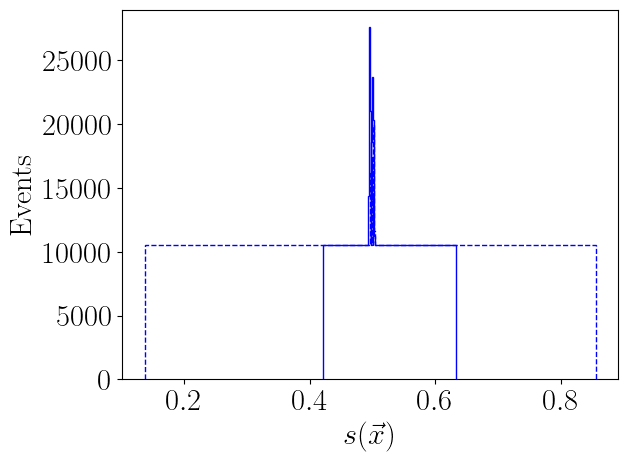

In [14]:
plt.hist(s_values,bins=s_bins,histtype='step',color='blue',density=False);
plt.hist(s_values_old,bins=s_bins_old,histtype='step',color='blue',linestyle='dashed',density=False);
plt.xlabel(r'$s(\vec{x})$')
plt.ylabel(r'Events')


Estimate the binned pdfs and with them the Mutual Information

In [15]:
pD, bb1, bb2 = np.histogram2d(s_values,y_together_bis,bins=[s_bins,y_bins],density=True)
pD_norm = np.array(list(map(lambda indx: list(map(lambda indy: pD[indx,indy]*(s_bins[indx+1]-s_bins[indx])*(y_bins[indy+1]-y_bins[indy]), range(len(y_bins)-1))), range(len(s_bins)-1))))
    #             print(np.min(pD_norm),np.sum(pD_norm))
pD_marg_s = np.sum(pD_norm,axis=1)
pD_marg_s=pD_marg_s/np.sum(pD_marg_s)
pD_marg_y = np.sum(pD_norm,axis=0)
pD_marg_y=pD_marg_y/np.sum(pD_marg_y)

pD_from_marg = np.array(list(map(lambda indx: list(map(lambda indy: pD_marg_s[indx]*pD_marg_y[indy], range(len(y_bins)-1))), range(len(s_bins)-1))))

print(np.min(pD_norm),np.min(pD_marg_s),np.min(pD_marg_y))
I_measured_new = max([mutual_info(pD_norm,pD_marg_s,pD_marg_y),0.0])
print(I_measured_new)

pD_old, bb1, bb2 = np.histogram2d(s_values_old,y_together_bis,bins=[s_bins_old,y_bins],density=True)
pD_old_norm = np.array(list(map(lambda indx: list(map(lambda indy: pD_old[indx,indy]*(s_bins_old[indx+1]-s_bins_old[indx])*(y_bins[indy+1]-y_bins[indy]), range(len(y_bins)-1))), range(len(s_bins_old)-1))))
    #             print(np.min(pD_norm),np.sum(pD_norm))
pD_old_marg_s = np.sum(pD_old_norm,axis=1)
pD_old_marg_s=pD_old_marg_s/np.sum(pD_old_marg_s)
pD_old_marg_y = np.sum(pD_old_norm,axis=0)
pD_old_marg_y=pD_old_marg_y/np.sum(pD_old_marg_y)

pD_old_from_marg = np.array(list(map(lambda indx: list(map(lambda indy: pD_old_marg_s[indx]*pD_old_marg_y[indy], range(len(y_bins)-1))), range(len(s_bins_old)-1))))

print(np.min(pD_old_norm),np.min(pD_old_marg_s),np.min(pD_old_marg_y))
I_measured_old = max([mutual_info(pD_old_norm,pD_old_marg_s,pD_old_marg_y),0.0])
print(I_measured_old)

0.00141235092953321 0.0416643524212297 0.041664352421229685
0.0008530500078479297
0.0013449072053701074 0.04166038514333775 0.04166435242122969
0.0014019005360461781


In [16]:
significance = np.sum(labels_together_bis)/np.sqrt(np.sum(labels_together_bis==0.0))

Asymptotic p-values

In [17]:
asymptotic_distr = st.gamma(a=0.5*(len(s_bins)-2)*(len(y_bins)-2),scale=1.0/(len(s_values_filtered)))
print(asymptotic_distr.sf(I_measured_new))

0.0012265129899627961


In [18]:
print(st.norm.isf(asymptotic_distr.sf(I_measured_new)))
if nS > 0.0:
    print(st.norm.isf(asymptotic_distr.sf(I_measured_new))/significance)

3.0290764518950724
2.3547664533430885


In [19]:
asymptotic_distr_old = st.gamma(a=0.5*(len(s_bins_old)-2)*(len(y_bins)-2),scale=1.0/(len(s_values_filtered_old)))
print(asymptotic_distr_old.sf(I_measured_old))
print(st.norm.isf(asymptotic_distr_old.sf(I_measured_old)))
if nS > 0.0:
    print(st.norm.isf(asymptotic_distr_old.sf(I_measured_old))/significance)

9.957639030347958e-13
7.035075748937085
5.468980606270415


I can do the same for simulations

In [20]:
# number of bins given by uncertainty... assume MC uncertainty where Delta N = sqrt(N), I want sqrt(N)/N = x -> N =(1/x)^2

s_nbins_sim = round(len(s_values_sim)*rel_uncertainty**2)
print(s_nbins_sim)


24


In [21]:
# some bins may end up empty because I force to split them
# s_bins = np.array([0.0]+list(np.linspace(np.quantile(s_values,1*1.0/(s_nbins-1)),np.quantile(s_values,(s_nbins-2)*1.0/(s_nbins-1)),s_nbins))+[1.0])
s_bins_sim = np.array([np.quantile(s_values_sim,i*1.0/(s_nbins_sim-1)) for i in range(s_nbins_sim) ])
s_bins_sim = np.unique(s_bins_sim)

s_values_binned_sim, s_bins_sim = np.histogram(s_values_sim,bins=s_bins_sim)

while np.sum(1.0/np.sqrt(s_values_binned_sim) > rel_uncertainty) > 0:
#     print(s_bins)
    bins_to_merge = []
    nbin = np.where(1.0/np.sqrt(s_values_binned_sim) > rel_uncertainty)[0][0]
#     print(nbin)
    if nbin == 0:
        bins_to_merge=[1]
    elif nbin == len(s_values_binned_sim)-1:
        bins_to_merge=[len(s_values_binned_sim)-1]
    else:
        if s_values_binned_sim[nbin-1] < s_values_binned_sim[nbin+1]:
            bins_to_merge=[nbin]
        else:
            bins_to_merge=[nbin+1]
    s_bins_sim = np.delete(s_bins_sim,bins_to_merge)
    s_values_binned_sim, s_bins_sim = np.histogram(s_values_sim,bins=s_bins_sim)
    
print(len(s_bins_sim))

indexes_s = [a and b for a, b in zip(s_values_sim>=s_bins_sim[0],s_values_sim<=s_bins_sim[-1])]
indexes_y = [a and b for a, b in zip(y_sim_bis>=y_bins[0],y_sim_bis<y_bins[-1])]

indexes = [ a and b for a,b in zip(indexes_s,indexes_y)]

s_values_sim_filtered = s_values_sim[indexes]
labels_sim_mixture_filtered = labels_sim_mixture[indexes]
y_sim_bis_filtered = y_sim_bis[indexes]

18


In [22]:
pD_sim, bb1, bb2 = np.histogram2d(s_values_sim,y_sim_bis,bins=[s_bins_sim,y_bins],density=True)
pD_sim_norm = np.array(list(map(lambda indx: list(map(lambda indy: pD_sim[indx,indy]*(s_bins_sim[indx+1]-s_bins_sim[indx])*(y_bins[indy+1]-y_bins[indy]), range(len(y_bins)-1))), range(len(s_bins_sim)-1))))
    #             print(np.min(pD_norm),np.sum(pD_norm))
pD_sim_marg_s = np.sum(pD_sim_norm,axis=1)
pD_sim_marg_s=pD_sim_marg_s/np.sum(pD_sim_marg_s)
pD_sim_marg_y = np.sum(pD_sim_norm,axis=0)
pD_sim_marg_y=pD_sim_marg_y/np.sum(pD_sim_marg_y)

pD_sim_from_marg = np.array(list(map(lambda indx: list(map(lambda indy: pD_sim_marg_s[indx]*pD_sim_marg_y[indy], range(len(y_bins)-1))), range(len(s_bins_sim)-1))))

print(np.min(pD_sim_norm),np.min(pD_sim_marg_s),np.min(pD_sim_marg_y))
I_sim_new = max([mutual_info(pD_sim_norm,pD_sim_marg_s,pD_sim_marg_y),0.0])
print(I_sim_new)

0.0012789069392842977 0.04315096767926956 0.03953684142363388
0.0015300187380940492


# Plot generator

In [23]:
mycolors = [(1., 0.4, 0.0), (0.655728, 0.8, 0.),
   (0., 0.742291, 0.873126), (1., 0.656408, 0.), 
   (0.893126, 0.4, 0.767184), 
   (0.295048, 0.8, 0.286932), 
   (0.238758, 0.610466, 1.), (1., 0.325204, 0.406504),
    (0., 0.786874, 0.739379), (1., 0.520437, 0.), 
   (0.7529330319872088, 0.4176501130047967, 1.), 
   (0.5572809000084149, 0.8, 0), 
   (1., 0.06811595600706821, 0.0851449450088353), (0, 0.7226017980018511, 0.9321946059944466), 
   (1., 0.7154761789941944, 0)];

Plot the output distributions

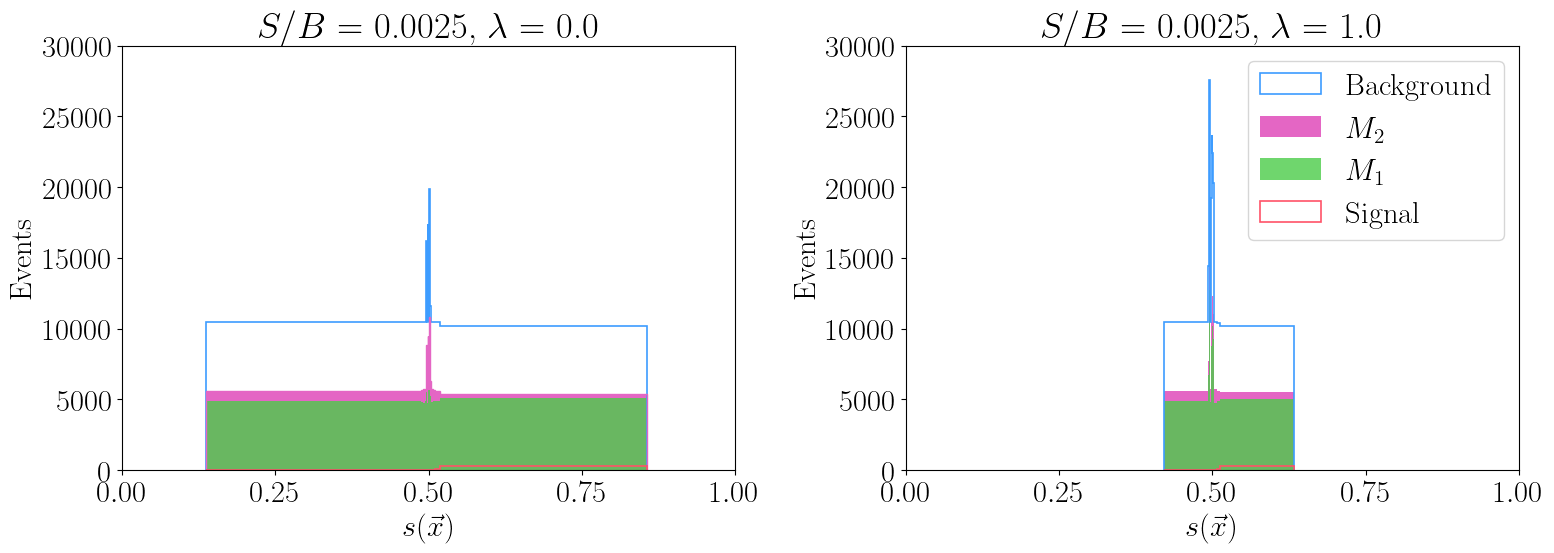

In [24]:
fig, ax = plt.subplots(1,2,figsize=(2*2*4,2*3))

ax[0].set_title(r'$S/B$ = '+SoverB_label+', $\lambda$ = '+str(lambda_val_old))
ax[0].hist(s_values_filtered_old[labels_together_filtered==0.0],bins=s_bins_old,histtype='step',color=mycolors[6], linewidth=1.2,alpha=1,label='Background');
ax[0].hist(s_values_filtered_old[labels_mixture_together_filtered==0.0],bins=s_bins_old,histtype='stepfilled',color=mycolors[4],alpha=1,label='$M_{2}$');
ax[0].hist(s_values_filtered_old[labels_mixture_together_filtered==1.0],bins=s_bins_old,histtype='stepfilled',color=mycolors[5],alpha=0.8,label='$M_{1}$');
ax[0].hist(s_values_filtered_old[labels_mixture_together_filtered==0.0],bins=s_bins_old,histtype='step',color=mycolors[4],alpha=1);
if nS > 0.0:
    ax[0].hist(s_values_filtered_old[labels_together_filtered==1.0],bins=s_bins_old,histtype='step',color=mycolors[7], linewidth=1.2,alpha=1,label='Signal');
ax[0].set_xlabel(r'$s(\vec{x})$')
ax[0].set_ylabel('Events')

ax[1].set_title(r'$S/B$ = '+SoverB_label+', $\lambda$ = '+str(lambda_val))
ax[1].hist(s_values_filtered[labels_together_filtered==0.0],bins=s_bins,histtype='step',color=mycolors[6],alpha=1, linewidth=1.2,label='Background');
ax[1].hist(s_values_filtered[labels_mixture_together_filtered==0.0],bins=s_bins,histtype='stepfilled',color=mycolors[4],alpha=1,label='$M_{2}$');
ax[1].hist(s_values_filtered[labels_mixture_together_filtered==1.0],bins=s_bins,histtype='stepfilled',color=mycolors[5],alpha=0.8,label='$M_{1}$');

if nS > 0.0:
    ax[1].hist(s_values_filtered[labels_together_filtered==1.0],bins=s_bins,histtype='step',color=mycolors[7],alpha=1, linewidth=1.2,label='Signal');
ax[1].set_xlabel(r'$s(\vec{x})$')
ax[1].set_ylabel(r'Events')

ax[0].set_xlim(0,1)
ax[0].set_xticks(np.arange(0.0,1.25,0.25))
ax[1].set_xticks(np.arange(0.0,1.25,0.25))
ax[1].set_xlim(0,1)
ax[1].legend(loc='upper right')
ax[0].set_ylim(0,30000)
ax[1].set_ylim(0,30000)
plt.tight_layout()
plt.savefig(results_dir+'new_plot_'+SoverB_label[2:]+'.pdf')

Run pseudo-experiments and compute the numerical distribution of the MI

In [25]:
Nseudo_exp = 10000
datasets_from_data_marginals=np.array(list(map(lambda indx: list(map(lambda indy: st.poisson.rvs(mu=(len(s_values))*pD_from_marg[indx,indy],size=Nseudo_exp), range(len(y_bins)-1))), range(len(s_bins)-1))))
datasets_from_data_marginals=np.swapaxes(datasets_from_data_marginals,2,1)
datasets_from_data_marginals=np.swapaxes(datasets_from_data_marginals,0,1)

datasets_from_data_marginals_old=np.array(list(map(lambda indx: list(map(lambda indy: st.poisson.rvs(mu=(len(s_values_old))*pD_old_from_marg[indx,indy],size=Nseudo_exp), range(len(y_bins)-1))), range(len(s_bins_old)-1))))
datasets_from_data_marginals_old=np.swapaxes(datasets_from_data_marginals_old,2,1)
datasets_from_data_marginals_old=np.swapaxes(datasets_from_data_marginals_old,0,1)

In [26]:
Nsampled=np.sum(np.sum(datasets_from_data_marginals,axis=2),axis=1)
Nsampled_old=np.sum(np.sum(datasets_from_data_marginals_old,axis=2),axis=1)

In [27]:
pD_sampled = np.array(list(map(lambda nseudo : datasets_from_data_marginals[nseudo]/Nsampled[nseudo],range(Nseudo_exp))))
pD_sampled_old = np.array(list(map(lambda nseudo : datasets_from_data_marginals_old[nseudo]/Nsampled_old[nseudo],range(Nseudo_exp))))

In [28]:
pD_marg_s_sampled = np.sum(pD_sampled,axis=2)
pD_marg_y_sampled = np.sum(pD_sampled,axis=1)

pD_marg_s_sampled_old = np.sum(pD_sampled_old,axis=2)
pD_marg_y_sampled_old = np.sum(pD_sampled_old,axis=1)

In [29]:
mutual_info_sampled = np.array(list(map(lambda nseudo : mutual_info(pD_sampled[nseudo],pD_marg_s_sampled[nseudo],pD_marg_y_sampled[nseudo]),range(Nseudo_exp))))
mutual_info_sampled_old = np.array(list(map(lambda nseudo : mutual_info(pD_sampled_old[nseudo],pD_marg_s_sampled_old[nseudo],pD_marg_y_sampled_old[nseudo]),range(Nseudo_exp))))

And now the Mutual Information plot

3.0291325951538965 2.3548100984159546


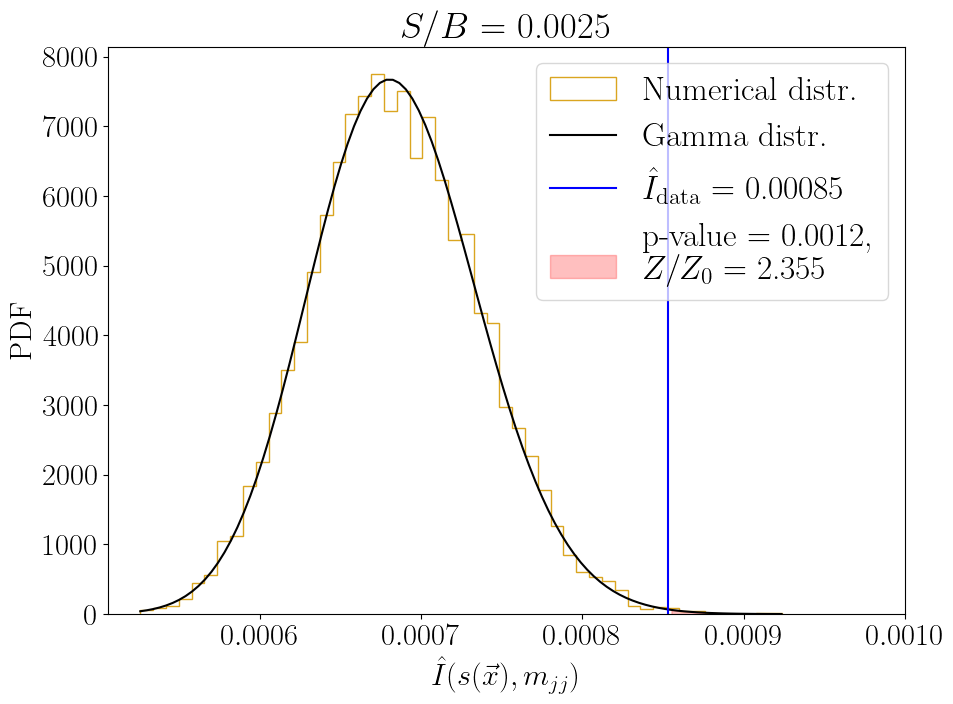

In [30]:
plt.figure(figsize=(2.5*4,2.5*3))

aa, bb, cc = plt.hist(mutual_info_sampled,density=True,label='Numerical distr.',linestyle='solid',histtype='step',bins=50,color='goldenrod');
mi_vals = np.linspace(np.min(mutual_info_sampled),np.max(mutual_info_sampled),100)


asymptotic_distr = st.gamma(a=0.5*(len(s_bins)-2)*(len(y_bins)-2),scale=1.0/(len(s_values)))
asymptotic=asymptotic_distr.pdf(mi_vals)
plt.plot(mi_vals,asymptotic,label=r'$\mathrm{Gamma}$ distr.',color='black')
pval = asymptotic_distr.sf(I_measured_new)
significance_new = st.norm.isf(pval)
if nS > 0.0:
    print(significance_new,significance_new/significance)
    label_plot = 'p-value = '+str(round(pval,4))+',\n'+r'$Z/Z_{0}$ = '+str(round(significance_new/significance,3))
else:
    label_plot = 'p-value = '+str(round(pval,4))
if I_measured_new <= mi_vals[-1]:
    plt.axvline(I_measured_new,label=r'$\hat{I}_{\mathrm{data}}$ = '+str(round(I_measured_new,5)),color='blue')
    plt.fill_between(y1=asymptotic[mi_vals>=I_measured_new],x=mi_vals[mi_vals>=I_measured_new],color='red',alpha=0.25,label=label_plot)
else:
    plt.axvline(I_measured_new,label=r'$\hat{I}_{\mathrm{data}}$ = '+str(round(I_measured_new,5)),color='blue')
    plt.fill_between(y1=asymptotic[mi_vals>=I_measured_new],x=mi_vals[mi_vals>=I_measured_new],color='red',alpha=0.25,label=label_plot)
    plt.xlim((np.min(mutual_info_sampled),np.max(mutual_info_sampled)))

plt.legend(loc='upper right',framealpha=0.75,fontsize=24)
plt.xlabel(r'$\hat{I}(s(\vec{x}),m_{jj})$')
plt.ylabel('PDF')
plt.ylim(0.0)
plt.xticks(np.arange(0.0006,0.001,0.0001))

plt.title(r'$S/B$ = '+SoverB_label)#+r', $\lambda$ = '+str(lambda_val))#,'+'\n'+r'$\hat{I}(s(\vec{x}),m_{jj})$ = '+str(round(I_measured_new,5))+', p-value = '+str(round(pval,6)))
plt.tight_layout()
plt.savefig(results_dir+'mutual_information_'+SoverB_label[2:]+'.pdf')